In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from numba import njit, types
from numba.typed import List

import matplotlib.pyplot as plt
import base64
from io import BytesIO
import os

# ---------------------------
# 1) Bollinger Strategy with Numba
# ---------------------------
@njit
def generate_positions_numba(long_entry, short_entry, long_exit, short_exit, valid):
    """
    Low-level function to assign position (-1,0,+1) for each bar.
    """
    n = len(long_entry)
    pos = np.zeros(n, dtype=np.int8)
    current_pos = 0
    for i in range(n):
        if not valid[i]:  # not enough rolling data
            current_pos = 0
        else:
            if current_pos == 0:
                # enter
                if long_entry[i]:
                    current_pos = 1
                elif short_entry[i]:
                    current_pos = -1
            else:
                # exit
                if current_pos == 1 and long_exit[i]:
                    current_pos = 0
                elif current_pos == -1 and short_exit[i]:
                    current_pos = 0
        pos[i] = current_pos
    return pos

def bollinger_band_strategy_numba(data, lookback=20, sdev=2):
    """
    Compute Bollinger signals with Numba-accelerated loop for position assignment.
    """
    close = data['close']
    rolling_mean = close.rolling(lookback).mean()
    rolling_std  = close.rolling(lookback).std()
    upper_band   = rolling_mean + sdev * rolling_std
    lower_band   = rolling_mean - sdev * rolling_std

    long_entry  = (close < lower_band)
    short_entry = (close > upper_band)
    long_exit   = (close > rolling_mean)
    short_exit  = (close < rolling_mean)
    valid       = ~rolling_mean.isna()

    # Convert to numpy arrays
    le_arr = long_entry.to_numpy(dtype=np.bool_)
    se_arr = short_entry.to_numpy(dtype=np.bool_)
    lx_arr = long_exit.to_numpy(dtype=np.bool_)
    sx_arr = short_exit.to_numpy(dtype=np.bool_)
    valid_arr = valid.to_numpy(dtype=np.bool_)

    positions = generate_positions_numba(le_arr, se_arr, lx_arr, sx_arr, valid_arr)

    signals = pd.DataFrame({
        'rolling_mean': rolling_mean,
        'rolling_std': rolling_std,
        'upper_band': upper_band,
        'lower_band': lower_band,
        'position': positions
    }, index=data.index)

    return signals

# ---------------------------
# 2) Extract Trades
# ---------------------------


@njit
def _extract_trades_numba(position_arr, close_arr):
    """
    Numba-compiled function to identify trades from a position array.
    
    Parameters
    ----------
    position_arr : 1D np.array of int8   (the -1,0,+1 position at each bar)
    close_arr    : 1D np.array of float64 (the close price at each bar)
    
    Returns
    -------
    A tuple of typed lists (parallel arrays):
      entry_idx_list  : where each trade starts (integer index)
      exit_idx_list   : where each trade ends   (integer index)
      entry_px_list   : entry prices
      exit_px_list    : exit prices
      direction_list  : +1 for long, -1 for short
      profit_pct_list : trade profit as a percent
      profit_pnl_list : trade profit in currency
    """
    n = len(position_arr)

    in_trade = False
    entry_idx = -1
    entry_price = 0.0
    direction = np.int8(0)

    # Create empty typed lists for results
    entry_idx_list  = List.empty_list(types.int64)
    exit_idx_list   = List.empty_list(types.int64)
    entry_px_list   = List.empty_list(types.float64)
    exit_px_list    = List.empty_list(types.float64)
    direction_list  = List.empty_list(types.int8)
    profit_pct_list = List.empty_list(types.float64)
    profit_pnl_list = List.empty_list(types.float64)

    for i in range(n):
        curr_pos = position_arr[i]
        curr_px  = close_arr[i]

        if not in_trade:
            # Look for an entry (position goes from 0 to ±1)
            if curr_pos != 0:
                in_trade = True
                entry_idx = i
                entry_price = curr_px
                direction = np.int8(curr_pos)
        else:
            # We are in a trade; check for exit (position == 0)
            if curr_pos == 0:
                # record trade
                exit_idx = i
                exit_px = curr_px
                if direction == 1:
                    profit_pct = (exit_px / entry_price - 1.0)
                    profit_pnl = exit_px - entry_price
                else:
                    profit_pct = (entry_price / exit_px - 1.0)
                    profit_pnl = entry_price - exit_px

                entry_idx_list.append(entry_idx)
                exit_idx_list.append(exit_idx)
                entry_px_list.append(entry_price)
                exit_px_list.append(exit_px)
                direction_list.append(direction)
                profit_pct_list.append(profit_pct)
                profit_pnl_list.append(profit_pnl)

                # reset
                in_trade = False
                entry_idx = -1
                entry_price = 0.0
                direction = np.int8(0)

    # If still in a trade at the end, exit on the last bar
    if in_trade:
        i = n - 1
        exit_idx = i
        exit_px  = close_arr[i]
        if direction == 1:
            profit_pct = (exit_px / entry_price - 1.0)
            profit_pnl = exit_px - entry_price
        else:
            profit_pct = (entry_price / exit_px - 1.0)
            profit_pnl = entry_price - exit_px

        entry_idx_list.append(entry_idx)
        exit_idx_list.append(exit_idx)
        entry_px_list.append(entry_price)
        exit_px_list.append(exit_px)
        direction_list.append(direction)
        profit_pct_list.append(profit_pct)
        profit_pnl_list.append(profit_pnl)

    return (entry_idx_list, exit_idx_list,
            entry_px_list, exit_px_list,
            direction_list, profit_pct_list, profit_pnl_list)


def extract_trades(signals, data):
    """
    Parameters
    ----------
    signals : pd.DataFrame with at least 'position' (int64 or int8) 
    data    : pd.DataFrame with at least 'close'; 
              optionally has 'timestamp' column or DatetimeIndex
    
    Returns
    -------
    trades: list of dictionaries
    """
    # 1) Convert 'position' to an int8 array (no more -1,0,1 than fits in int8).
    position_arr = signals['position'].to_numpy(dtype=np.int8)
    sdevs = signals['rolling_std'].to_numpy()

    # 2) Convert 'close' to float64
    close_arr = data['close'].to_numpy(dtype=np.float64)

    # 3) Run the Numba extraction
    (entry_idx_list, exit_idx_list,
     entry_px_list, exit_px_list,
     direction_list, profit_pct_list, profit_pnl_list) = _extract_trades_numba(position_arr, close_arr)

    # 4) Build final result: a list of dicts
    trades = []
    for i in range(len(entry_idx_list)):
        ent_i = entry_idx_list[i]
        ext_i = exit_idx_list[i]

        # Decide how to grab timestamps:
        if 'timestamp' in data.columns:
            # Then use the column
            entry_time = data['timestamp'].iloc[ent_i]
            exit_time  = data['timestamp'].iloc[ext_i]
        else:
            # Fallback: use the DataFrame's index
            entry_time = data.index[ent_i]
            exit_time  = data.index[ext_i]

        trade_dict = {
            'entry_time'  : entry_time,
            'exit_time'   : exit_time,
            'entry_price' : entry_px_list[i],
            'exit_price'  : exit_px_list[i],
            'direction'   : direction_list[i],
            'profit_pct'  : profit_pct_list[i],
            'profit_pnl'  : profit_pnl_list[i],
            'sdev'        : sdevs[i]
        }
        trades.append(trade_dict)

    return trades


# ---------------------------
# 3) Apply Spread & Fees
# ---------------------------
def apply_spread_and_fees(trades: pd.DataFrame, spread=0.0, fees=0.0) -> pd.DataFrame:
    """
    Adjust each trade for a fixed spread per side (entry & exit) and a per-trade fee.
    
    The convention here is:
      - For a Long:
          entry_price = entry_price + spread   (buy at a worse/higher price)
          exit_price  = exit_price  - spread   (sell at a worse/lower price)
      - For a Short:
          entry_price = entry_price - spread   (short at a worse/lower price)
          exit_price  = exit_price  + spread   (cover at a worse/higher price)

    Then we subtract an additional `fees` from the final PnL (a fixed dollar cost).

    Parameters
    ----------
    trades : pd.DataFrame
        Each row must have:
          'direction' in {+1, -1}
          'entry_price', 'exit_price'
          'profit_pct', 'profit_pnl' 
    spread : float
        The fixed spread in dollars for 1 share (applied on both entry & exit).
        (If you trade multiple shares, you'd multiply accordingly.)
    fees : float
        A fixed dollar amount subtracted from each trade’s final PnL.

    Returns
    -------
    pd.DataFrame
        A new DataFrame with updated 'entry_price', 'exit_price', 
        'profit_pct', and 'profit_pnl' columns.
    """

    adj_trades = trades.copy()

    for i, row in adj_trades.iterrows():
        direction = row['direction']
        entry_px  = row['entry_price']
        exit_px   = row['exit_price']

        # ---- 1) Apply spread depending on direction ----
        if direction == 1:  # Long
            # Buy at higher price
            entry_px += spread
            # Sell at lower price
            exit_px  -= spread
        else:  # direction == -1 (Short)
            # Short at lower price (worse fill for a short)
            entry_px -= spread
            # Cover at higher price (worse fill for a short)
            exit_px  += spread

        # ---- 2) Recompute PnL ignoring fees for the moment ----
        if direction == 1:
            trade_pnl = exit_px - entry_px
        else:  # direction == -1
            trade_pnl = entry_px - exit_px

        # ---- 3) Subtract fixed fee from final PnL ----
        trade_pnl -= fees

        # ---- 4) Recompute profit_pct with the new prices ----
        if direction == 1:
            profit_pct = (exit_px / entry_px - 1.0)
        else:
            profit_pct = (entry_px / exit_px - 1.0)

        # ---- 5) Store updated values ----
        adj_trades.at[i, 'entry_price'] = entry_px
        adj_trades.at[i, 'exit_price']  = exit_px
        adj_trades.at[i, 'profit_pnl']  = trade_pnl
        adj_trades.at[i, 'profit_pct']  = profit_pct

    return adj_trades


# ---------------------------
# 4) Build Equity Curve (Unadjusted for spread/fees)
# ---------------------------
def build_equity_curve(data, signals, initial_capital=1_000_000, shift_bars=1):
    df = data[['close']].copy()
    df['position'] = signals['position']
    df['market_return'] = df['close'].pct_change()
    df['position_lag'] = df['position'].shift(shift_bars).fillna(0)
    df['strategy_return'] = df['position_lag'] * df['market_return']
    df['equity_curve'] = (1 + df['strategy_return']).cumprod() * initial_capital
    df.dropna(subset=['equity_curve'], inplace=True)
    return df

def build_equity_curve(data, signals, shift_bars=1):
    """
    Build a raw USD equity curve by cumulatively summing the bar-by-bar 
    profit/loss, ignoring any initial capital or percentage compounding.

    Parameters
    ----------
    data    : pd.DataFrame
        Must contain a 'close' column (and index as time).
    signals : pd.DataFrame
        Must contain a 'position' column (the # of units held: +1 for long 1 share, etc.).
    shift_bars : int
        Number of bars to shift the 'position' if you want to simulate trade-lag 
        or next-bar execution. Defaults to 1.

    Returns
    -------
    df : pd.DataFrame
        Columns:
          'close'
          'position'       (from signals)
          'delta_close'
          'position_lag'
          'strategy_dollar_return'
          'equity_curve'
        The 'equity_curve' starts at 0 and accumulates raw USD PnL.
    """
    df = data[['close']].copy()
    df['position'] = signals['position']

    # 1) delta_close is the price change each bar
    df['delta_close'] = df['close'].diff()

    # 2) Optionally shift the position to simulate next-bar fills (or N bars later)
    df['position_lag'] = df['position'].shift(shift_bars).fillna(0)

    # 3) Dollar PnL each bar = position_lag * price_change
    df['strategy_dollar_return'] = df['position_lag'] * df['delta_close']

    # 4) Cumulative sum of these returns => raw USD equity curve
    #    Starts at 0; grows or shrinks as we sum bar-by-bar PnLs.
    df['equity_curve'] = df['strategy_dollar_return'].cumsum()

    # 5) Drop NaNs caused by the first diff() (optional)
    df.dropna(subset=['equity_curve'], inplace=True)

    return df


# ---------------------------
# 5) Compute Drawdown
# ---------------------------
def compute_drawdown(equity_series):
    roll_max = equity_series.cummax()
    return (equity_series - roll_max) / roll_max


def analyze_bollinger(data,
                      lookback,
                      sdev,
                      initial_capital=1_000_000,
                      shift_bars=1,
                      spread=0.0,
                      fees=0.0):
    """
    1) Generate signals
    2) Extract trades
    3) Apply spread & fees to trades
    4) Build equity curve (still ignoring costs at bar-level)
    5) Compute stats from updated trades, including median trade time in minutes
    """
    # 1) Generate signals
    signals = bollinger_band_strategy_numba(data, lookback=lookback, sdev=sdev)

    # 2) Extract raw trades
    trades_list = extract_trades(signals, data)
    trades = pd.DataFrame(trades_list)

    # 3) Adjust trades for spread & fees -> REASSIGN 'trades'!
    if not trades.empty:
        trades = apply_spread_and_fees(trades, spread=spread, fees=fees)

    # 4) Build equity curve from raw signals (no cost in bar returns)
    ec_df = build_equity_curve(data=data, signals=signals)
    ec_df['drawdown'] = compute_drawdown(ec_df['equity_curve'])

    # 5) Summarize stats
    stats = {}
    stats['lookback']   = lookback
    stats['sdev']       = sdev
    stats['spread']     = spread
    stats['fees_pct']   = fees
    stats['shift_bars'] = shift_bars

    stats['final_equity'] = ec_df['equity_curve'].iloc[-1]
    stats['return_pct']   = (ec_df['equity_curve'].iloc[-1] / ec_df['equity_curve'].iloc[0] - 1)
    stats['max_drawdown_pct'] = ec_df['drawdown'].min()
    stats['time_in_market_pct'] = (signals['position'] != 0).mean()
    stats['return_pct'] = ((ec_df['equity_curve'].iloc[-1] / ec_df['equity_curve'].iloc[0]) - 1)

    ret_bar = ec_df['strategy_return'].dropna()
    if ret_bar.std() > 0:
        stats['sharpe'] = (ret_bar.mean() / ret_bar.std()) * np.sqrt(252*390)
    else:
        stats['sharpe'] = float('nan')

    # ----- Trade-level stats AFTER applying fees/spread -----
    total_trades = len(trades)
    stats['num_trades'] = total_trades
    if total_trades > 0:
        wins = trades[trades['profit_pnl'] > 0]
        losses = trades[trades['profit_pnl'] < 0]
        stats['win_rate_pct'] = len(wins) / total_trades
        stats['avg_win_pct']  = wins['profit_pct'].mean() if not wins.empty else 0
        stats['avg_loss_pct'] = losses['profit_pct'].mean() if not losses.empty else 0
        stats['avg_win_pnl']  = wins['profit_pnl'].mean() if not wins.empty else 0
        stats['avg_loss_pnl'] = losses['profit_pnl'].mean() if not losses.empty else 0
        # ----- ADD: average profit per trade in absolute terms -----
        stats['avg_profit_per_trade'] = trades['profit_pnl'].mean()

        # ----- ADD: average profit per trade in percentage terms -----
        # (Here, trades['profit_pct'] is the % gain/loss for each trade.)
        stats['avg_profit_per_trade_pct'] = trades['profit_pct'].mean()

        # ----- Median Trade Time in Minutes -----
        # Ensure entry_time, exit_time are timestamps or convert them:
        trade_durations = pd.to_datetime(trades['exit_time']) - pd.to_datetime(trades['entry_time'])
        stats['median_trade_time_mins'] = trade_durations.median().total_seconds() / 60.0
    else:
        stats['win_rate_pct']           = 0
        stats['avg_win_pct']            = 0
        stats['avg_loss_pct']           = 0
        stats['avg_win_pnl']            = 0
        stats['avg_loss_pnl']           = 0
        stats['median_trade_time_mins'] = 0
        stats['avg_profit_per_trade']   = 0
        stats['avg_profit_per_trade_pct'] = 0

    # 7) NEW: average_daily_profit
    #   a) find how many days from ec_df.index[0] to ec_df.index[-1]
    if len(ec_df) > 1:
        start_time = ec_df.index[0]
        end_time   = ec_df.index[-1]
        
        # check if it's DatetimeIndex
        if isinstance(start_time, pd.Timestamp) and isinstance(end_time, pd.Timestamp):
            total_days = (end_time - start_time).total_seconds() / 86400.0
        else:
            total_days = 0.0

        total_profit = stats['final_equity'] - initial_capital
        if total_days > 0:
            stats['average_daily_profit'] = total_profit / total_days
            stats['avg_trades_per_day']   = total_trades / total_days
        else:
            stats['average_daily_profit'] = 0.0
            stats['avg_trades_per_day']   = 0.0
    else:
        stats['average_daily_profit'] = 0.0
        stats['avg_trades_per_day']   = 0.0

    return ec_df, trades, stats


def build_equity_curve_raw(data, signals, shift_bars=1):
    """
    Build a raw USD equity curve by cumulatively summing the bar-by-bar 
    profit/loss, ignoring any initial capital or % returns.

    data    : pd.DataFrame with at least 'close' column (indexed by time).
    signals : pd.DataFrame with at least 'position' column (#units).
    shift_bars: int
        If 1, we assume we fill the position at the next bar, etc.
    
    Returns
    -------
    df : pd.DataFrame with columns:
      'close'
      'delta_close' : price[t] - price[t-1]
      'position_lag'
      'strategy_usd_return'
      'equity_curve' (cumulative sum starting at 0)
    """
    df = data[['close']].copy()
    df['position'] = signals['position']

    # Price change each bar
    df['delta_close'] = df['close'].diff()

    # Shift position for next-bar fill
    df['position_lag'] = df['position'].shift(shift_bars).fillna(0)

    # Bar-by-bar $ PnL
    df['strategy_usd_return'] = df['position_lag'] * df['delta_close']

    # Cumulative sum => raw USD equity curve, starts at 0
    df['equity_curve'] = df['strategy_usd_return'].cumsum()

    # Drop the first NaN row from diff()
    df.dropna(subset=['equity_curve'], inplace=True)

    return df

def analyze_bollinger_raw(data,
                          lookback,
                          sdev,
                          shift_bars=1,
                          spread=0.0,
                          fees=0.0):
    """
    A minimal version that:
      1) Generates signals from bollinger_band_strategy_numba
      2) Extracts trades
      3) Applies fees/spread
      4) Builds a raw USD equity curve (cumulative sum of barPnL)
      5) Computes raw-dollar stats (final_equity, max_drawdown_usd, average_daily_profit, etc.)
    """
    # 1) Generate signals
    signals = bollinger_band_strategy_numba(data, lookback=lookback, sdev=sdev)

    # 2) Extract trades from signals
    trades_list = extract_trades(signals, data)
    trades = pd.DataFrame(trades_list)

    # 3) If trades exist, apply fees/spread
    if not trades.empty:
        trades = apply_spread_and_fees(trades, spread=spread, fees=fees)

    # 4) Build raw USD equity curve
    ec_df = build_equity_curve_raw(data=data, signals=signals, shift_bars=shift_bars)

    # 5) Summarize stats in a dict
    stats = {}
    stats['lookback'] = lookback
    stats['sdev']     = sdev
    stats['spread']   = spread
    stats['fees']     = fees
    stats['shift_bars'] = shift_bars

    # Final equity is the last row of 'equity_curve'
    if not ec_df.empty:
        stats['final_equity'] = ec_df['equity_curve'].iloc[-1]
    else:
        stats['final_equity'] = 0.0

    # Max drawdown in USD (peak-to-valley)
    if not ec_df.empty:
        ec_df['cummax'] = ec_df['equity_curve'].cummax()
        ec_df['drawdown'] = ec_df['equity_curve'] - ec_df['cummax']
        stats['max_drawdown_usd'] = ec_df['drawdown'].min()
    else:
        stats['max_drawdown_usd'] = 0.0

    # Trades summary
    stats['num_trades'] = len(trades)
    if len(trades) > 0:
        wins   = trades[trades['profit_pnl'] > 0]
        losses = trades[trades['profit_pnl'] < 0]
        stats['win_rate_pct']    = len(wins) / len(trades)
        stats['avg_profit_trade'] = trades['profit_pnl'].mean()
        stats['avg_win_pnl']     = wins['profit_pnl'].mean() if not wins.empty else 0
        stats['avg_loss_pnl']    = losses['profit_pnl'].mean() if not losses.empty else 0
    else:
        stats['win_rate_pct']    = 0
        stats['avg_profit_trade'] = 0
        stats['avg_win_pnl']     = 0
        stats['avg_loss_pnl']    = 0

    # Average daily profit & trades/day if the index is Datetime
    if len(ec_df) > 1:
        start_time = ec_df.index[0]
        end_time   = ec_df.index[-1]
        if isinstance(start_time, pd.Timestamp) and isinstance(end_time, pd.Timestamp):
            total_days = (end_time - start_time).total_seconds() / 86400.0
        else:
            total_days = 0.0
        if total_days > 0:
            # final_equity - 0 => total net profit
            total_profit = stats['final_equity']
            stats['average_daily_profit'] = total_profit / total_days
            stats['avg_trades_per_day'] = len(trades) / total_days
        else:
            stats['average_daily_profit'] = 0
            stats['avg_trades_per_day']   = 0
    else:
        stats['average_daily_profit'] = 0
        stats['avg_trades_per_day']   = 0

    return ec_df, trades, stats



def run_grid_search(data, lookbacks, sdevs, spread=0):
    # We'll store final stats in a list of dicts
    results_list = []
    # We'll also store the detail objects so we can build the detail HTML
    detail_info = {}

    # --------- 1) Run the Grid Search -----------
    for lb in tqdm(lookbacks, desc="Grid Search"):
        for sd in sdevs:
            ec_df, trades, stats = analyze_bollinger_raw(
                data=data,  # or entire data
                lookback=lb,
                sdev=sd,
                spread=spread,
            )

            # We ensure 'lookback' and 'sdev' are in stats
            stats['lookback'] = lb
            stats['sdev'] = sd

            # Store final stats for the table
            results_list.append(stats)

            # Store the (ec_df, trades, stats) so we can build detail HTML
            detail_info[(lb, sd)] = (ec_df, trades, stats)

    # --------- 2) Create a DataFrame of all results -----------
    results_df = pd.DataFrame(results_list)
    return results_df

def aggregate_strategies_equity(data, strategies):
    """
    Runs multiple (lookback, sdev) strategies via analyze_bollinger,
    merges their raw USD equity curves, and sums them into 'aggregated_equity'.

    Parameters
    ----------
    data : pd.DataFrame
        Your market data (must have 'close' column, etc.) 
        to be passed into analyze_bollinger.
    strategies : list of tuples
        e.g. [(10, 2), (60, 2), (120, 3)]
        Each tuple is (lookback, sdev).

    Returns
    -------
    pd.DataFrame
        Merged DataFrame with columns:
          - 'equity_{lookback}_{sdev}' for each strategy
          - 'aggregated_equity' (the sum across columns)
        Indexed by the union of all timestamps from the strategies.

    Notes
    -----
    - This function calls `analyze_bollinger(...)` for each (lookback, sdev).
    - We assume `analyze_bollinger(...)` returns:
        ec_df, trades, stats
      and that `ec_df` has a 'equity_curve' column in raw USD.
    """

    import pandas as pd

    # Dictionary to store each strategy's ec_df
    results_dict = {}
    all_trades = []

    # 1) Run each strategy
    for (lb, sd) in tqdm(strategies):
        ec_df, trades, stats = analyze_bollinger_raw(
            data=data,
            lookback=lb,
            sdev=sd
        )
        # Store the ec_df for later merging
        results_dict[(lb, sd)] = ec_df
        all_trades.append(trades)

    # 2) Build a list of DataFrames, each renamed from 'equity_curve' -> e.g. 'equity_10_2'
    list_equities = []
    for (lb, sd), df in results_dict.items():
        col_name = f"equity_{lb}_{sd}"
        # keep only 'equity_curve', rename
        df_temp = df[['equity_curve']].rename(columns={'equity_curve': col_name})
        list_equities.append(df_temp)

    # 3) Concatenate side by side, outer join on the index
    merged_equities = pd.concat(list_equities, axis=1, join='outer')

    # 4) Fill missing with 0 (in case some strategy has shorter data range)
    merged_equities = merged_equities.fillna(0.0)

    # 5) Sum across columns to get aggregated_equity
    merged_equities['aggregated_equity'] = merged_equities.sum(axis=1)

    return merged_equities, all_trades


In [2]:
def get_data(ticker):
    data = pd.read_csv(f'../data/{ticker}_full_1min.txt', header=None, 
                       names=['date', 'time', 'open', 'high', 'low', 'close', 'volume'])
    data['date'] = pd.to_datetime(data['date'].astype(str) + ' ' + data['time'].astype(str), 
                                      format='%Y%m%d %H:%M:%S')
    data.set_index('date', inplace=True)
    data = data.sort_index()
    return data

In [3]:
def run_strategy_sweep(ticker, history=1_000_000, spread=0.0004):
    data = pd.read_csv(f'../../../Data/FirstRateData/FX/{ticker}_full_1min.txt', header=None, 
                       names=['date', 'time', 'open', 'high', 'low', 'close', 'volume'])
    data['date'] = pd.to_datetime(data['date'].astype(str) + ' ' + data['time'].astype(str), 
                                      format='%Y%m%d %H:%M:%S')
    data.set_index('date', inplace=True)
    data = data.sort_index()
    
    
    # Define the parameter grid
    lookbacks = [60, 70, 80, 90, 100, 110, 120, 150, 200, 300, 400, 500, 750, 1000]
    sdevs = [1, 2, 3, 4, 5, 6]
    
    results_df = run_grid_search(data[-history:], lookbacks=lookbacks, sdevs=sdevs)
    
    selected = results_df[results_df['avg_profit_trade'] > spread]
    
    selected = selected.copy()
    selected['avg_profit_trade'] -= spread
    selected['average_daily_profit'] = selected['avg_profit_trade'] * selected['avg_trades_per_day']
    selected.sort_values('average_daily_profit', ascending=False, inplace=True)
    selected.to_csv(f'asset_search/{ticker}.csv', index=False)

In [4]:
run_strategy_sweep('NZDJPY')

Grid Search: 100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:35<00:00,  2.54s/it]


In [5]:
tickers = [
    # 'USDCHF',
    # 'USDCAD',
    # 'AUDUSD',
    # 'EURUSD',
    # 'GBPUSD',
    # 'NZDUSD',
    'USDJPY',
    # 'AUDUSD',
    # 'AUDCHF',
    # 'NZDCAD',
    # 'NZDCHF',
    # 'EURAUD',
    # 'EURCAD',
    # 'EURCHF',
    # 'EURGBP',
    # 'GBPAUD',
    # 'GBPCHF',
    'AUDJPY',
    'NZDJPY',
]


In [7]:
data = get_data('NZDJPY')

In [8]:
results = pd.read_csv('asset_search/NZDJPY.csv')

In [9]:
results.sort_values('avg_profit_trade', ascending=False, inplace=True)

In [10]:
strategies = [(int(t['lookback']), int(t['sdev'])) for _, t in results.iloc[:10].iterrows()]

In [11]:
strategies

[(1000, 6),
 (750, 6),
 (1000, 5),
 (500, 6),
 (400, 6),
 (750, 5),
 (300, 6),
 (200, 6),
 (500, 5),
 (60, 6)]

In [12]:
out, trades = aggregate_strategies_equity(data, strategies)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.18it/s]


<Axes: xlabel='date'>

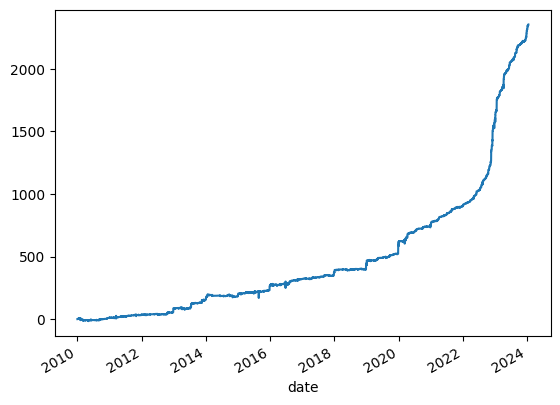

In [13]:
out['aggregated_equity'].plot()

In [14]:
17500 / results['num_trades'].sum()

0.03690752871405734

In [15]:
all_trades = pd.concat(trades)

In [16]:
all_trades.sort_values('entry_time', inplace=True)

<Axes: >

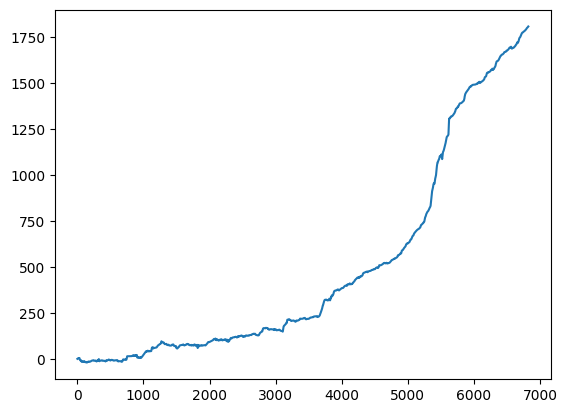

In [17]:
# Assumes 4 pip spread when buying, 4 pip spread when selling
(all_trades['profit_pnl']-0.08).cumsum().reset_index()['profit_pnl'].plot()

In [18]:
all_trades

,entry_time,exit_time,entry_price,exit_price,direction,profit_pct,profit_pnl,sdev
0,2010-01-06 19:30:00,2010-01-06 20:58:00,68.416,68.194,-1,0.003255,0.222,NaN
0,2010-01-06 19:33:00,2010-01-06 21:06:00,68.482,68.134,-1,0.005108,0.348,NaN
0,2010-01-07 17:09:00,2010-01-07 20:19:00,68.565,68.340,-1,0.003292,0.225,NaN
1,2010-01-07 17:09:00,2010-01-07 20:19:00,68.565,68.340,-1,0.003292,0.225,NaN
0,2010-01-07 17:09:00,2010-01-07 20:14:00,68.565,68.344,-1,0.003234,0.221,NaN
...,...,...,...,...,...,...,...,...
809,2024-01-11 08:29:00,2024-01-11 08:36:00,90.237,90.890,1,0.007236,0.653,0.155456
958,2024-01-11 08:29:00,2024-01-11 08:36:00,90.237,90.890,1,0.007236,0.653,0.138825
858,2024-01-11 12:59:00,2024-01-11 13:01:00,90.464,90.684,1,0.002432,0.220,0.144992
1096,2024-01-11 17:03:00,2024-01-11 19:02:00,90.282,90.646,1,0.004032,0.364,0.154875


In [19]:
all_trades.reset_index(inplace=True)

In [20]:
all_trades.drop('index', axis=1, inplace=True)

<Axes: >

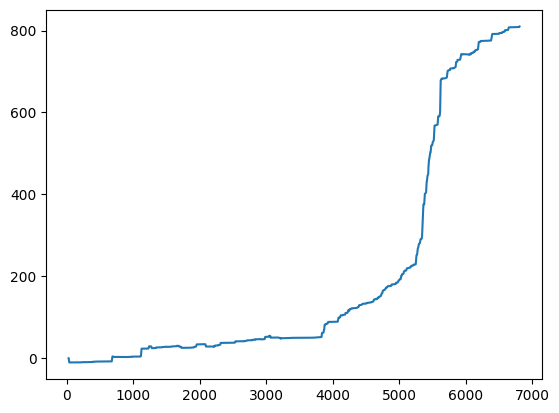

In [21]:
(all_trades[all_trades.entry_time.dt.hour==16]['profit_pnl']).cumsum().plot()

In [22]:
times = all_trades[all_trades.entry_time.dt.hour==16]['exit_time'] - all_trades[all_trades.entry_time.dt.hour==16]['entry_time']

In [23]:
times.median()

Timedelta('0 days 00:25:00')

In [24]:
times = all_trades[all_trades.entry_time.dt.hour==16]['exit_time'] - all_trades[all_trades.entry_time.dt.hour==16]['entry_time']

In [25]:
all_trades.corr()

/var/folders/zl/54zd_7b91f76wj0dp6dyfjfh0000gn/T/ipykernel_49389/1742535570.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  all_trades.corr()


,entry_price,exit_price,direction,profit_pct,profit_pnl,sdev
entry_price,1.000000,0.995971,0.158227,0.065602,0.105909,0.150541
exit_price,0.995971,1.000000,0.185693,0.134982,0.175201,0.161973
direction,0.158227,0.185693,1.000000,0.244617,0.249832,0.134588
profit_pct,0.065602,0.134982,0.244617,1.000000,0.994953,0.097536
profit_pnl,0.105909,0.175201,0.249832,0.994953,1.000000,0.110090
sdev,0.150541,0.161973,0.134588,0.097536,0.110090,1.000000


## Explanation of Critical Errors 2 and 3 (with Simple Numeric Examples and Notebook Code References)

**Error 2: Look-Ahead Bias**

Suppose you have a time series of closing prices for five bars:

| Time           | Close |
|----------------|-------|
| 10:00          | 100   |
| 10:01          | 101   |
| 10:02          | 102   |
| 10:03          | 99    | ← Signal triggers here (long entry condition met) |
| 10:04          | 103   |

With look-ahead bias, the strategy uses the closing price at 10:03 (which is 99) to decide to enter a trade at the same time. However, in reality, you do not know the closing price of 10:03 until that bar is finished. This means you are making a trading decision with information from the future, which is not possible in real trading.

**Where this happens in the notebook:**
- In the function `bollinger_band_strategy_numba`, the entry and exit signals are computed using the current bar's close price. For example, the code:

```python
long_entry  = (close < lower_band)
short_entry = (close > upper_band)
long_exit   = (close > rolling_mean)
short_exit  = (close < rolling_mean)
```

This means the signal is generated with information that is only available at the end of the bar, introducing look-ahead bias.

**Error 3: Inconsistency Between Trade Extraction and Equity Curve**

Let's see how this affects profit calculation:

- The trade extraction method assumes you enter at the closing price of 10:03 (99) and exit at the closing price of 10:04 (103), so the profit is 103 - 99 = 4.
- The equity curve method, with a one-bar shift, assumes you take the position at the next bar (10:04), but still calculates profit as if you entered at 99. In reality, you would enter at 103, not 99.

This inconsistency means that the two methods are not aligned: one assumes you can act on the current bar's close, the other delays the entry but does not adjust the entry price accordingly. As a result, the reported profits are artificially inflated, and the backtest does not reflect real trading conditions.

**Where this happens in the notebook:**
- The function `extract_trades` (and its Numba helper) records trades as if you enter and exit at the exact close price of the bar where the signal is generated. For example:

```python
# In _extract_trades_numba:
entry_price = curr_px
...
exit_px = curr_px
```

- The function `build_equity_curve` (and related code) uses a shifted position to simulate next-bar execution, but does not adjust the entry price accordingly. For example:

```python
df['position_lag'] = df['position'].shift(shift_bars).fillna(0)
df['strategy_dollar_return'] = df['position_lag'] * df['delta_close']
```

This creates a mismatch between the trade extraction logic and the equity curve logic.

**Summary:**

- With look-ahead bias, you use future information to make trading decisions, which is not possible in practice.
- With inconsistent entry/exit logic, your backtest results do not match what would happen in real trading, leading to misleading performance metrics.